In [1]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, pipeline, TrainingArguments, EarlyStoppingCallback, DataCollatorWithPadding
from transformers import DataCollatorWithPadding, AdamW, BertModel
from torch import nn

from datasets import Dataset
import torch
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import random
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [2]:
df = pd.read_csv('/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv', index_col=0)
df.head()

statement   status
0                                         oh my gosh  Anxiety
1  trouble sleeping, confused mind, restless hear...  Anxiety
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3  I've shifted my focus to something else but I'...  Anxiety
4  I'm restless and restless, it's been a month n...  Anxiety

In [3]:
df.dropna(inplace = True)
df.isna().sum()

statement    0
status       0
dtype: int64

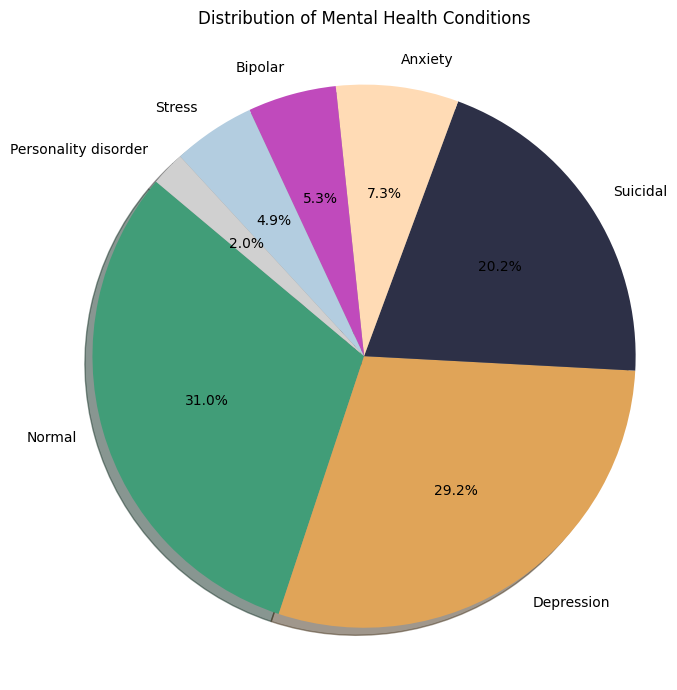

In [4]:
# Count the occurrences of each category
status_counts = df['status'].value_counts()

# Define colors for each category (7 colors)
colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', 
        startangle=140, colors=colors, shadow=True)

plt.title('Distribution of Mental Health Conditions')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Display the chart
plt.tight_layout()
plt.show()

In [5]:
# Group by status and get a random statement from each group
random_statements = df.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])

# Print the results
for status, statement in random_statements.items():
    print(f"Status: {status}")
    print(f"Statement: {statement}\n")

Status: Anxiety
Statement: every night overthinking, anxious, nervous..every time I do activities that I don't like, I always feel nauseous and have stomachaches. sometimes if you think too much it gives you a headache :(

Status: Bipolar
Statement: To depressed to shower? We all know to hit the hotspots with baby wipes, reapply deodorant, febreze clothes, spray some cologne, use some dry shampoo. But if your feet stink, the best, fastest way to curb it is to use a household antibacterial cleaning spray. A few squirts of 409 and your foot stank is a distant memory. 

Status: Depression
Statement: Life is pointless if you cannot enjoy anything. I exercise, work on my motorcycle, work, play video games, its all to kill the time. I turn 27 tomorrow, one year closer to death, woopty-fuckin-do. Wish someone would hit me on my motorcycle, but would feel bad knowing they would have to live with it. Anhedonia

Status: Normal
Statement: bored with rl >>> rp >>> bored with rp >>> flip rl >>> bor

In [6]:
df.rename(columns={'statement': 'original_statement'}, inplace=True)  

df['statement']=df['original_statement'].str.lower()
df.head()

original_statement   status  \
0                                         oh my gosh  Anxiety   
1  trouble sleeping, confused mind, restless hear...  Anxiety   
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3  I've shifted my focus to something else but I'...  Anxiety   
4  I'm restless and restless, it's been a month n...  Anxiety   

                                           statement  
0                                         oh my gosh  
1  trouble sleeping, confused mind, restless hear...  
2  all wrong, back off dear, forward doubt. stay ...  
3  i've shifted my focus to something else but i'...  
4  i'm restless and restless, it's been a month n...

In [7]:
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Apply the function to the 'statement' column
df['statement'] = df['statement'].apply(remove_patterns)
df.head()

original_statement   status  \
0                                         oh my gosh  Anxiety   
1  trouble sleeping, confused mind, restless hear...  Anxiety   
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3  I've shifted my focus to something else but I'...  Anxiety   
4  I'm restless and restless, it's been a month n...  Anxiety   

                                           statement  
0                                         oh my gosh  
1  trouble sleeping confused mind restless heart ...  
2  all wrong back off dear forward doubt stay in ...  
3  ive shifted my focus to something else but im ...  
4  im restless and restless its been a month now ...

In [8]:
# Apply word_tokenize to each element in the 'statement' column
df['tokens'] = df['statement'].apply(word_tokenize)
df.head() 

original_statement   status  \
0                                         oh my gosh  Anxiety   
1  trouble sleeping, confused mind, restless hear...  Anxiety   
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3  I've shifted my focus to something else but I'...  Anxiety   
4  I'm restless and restless, it's been a month n...  Anxiety   

                                           statement  \
0                                         oh my gosh   
1  trouble sleeping confused mind restless heart ...   
2  all wrong back off dear forward doubt stay in ...   
3  ive shifted my focus to something else but im ...   
4  im restless and restless its been a month now ...   

                                              tokens  
0                                     [oh, my, gosh]  
1  [trouble, sleeping, confused, mind, restless, ...  
2  [all, wrong, back, off, dear, forward, doubt, ...  
3  [ive, shifted, my, focus, to, something, else,...  
4  [im, restless, and, restless, its, been, a, mo...

In [ ]:
import transformers
from typing import Optional
# Thêm vào đầu code
import torch
torch.cuda.empty_cache()
torch.backends.cudnn.benchmark = True


import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'


label_mapping = {
    'Personality disorder': 0,
    'Normal': 1,
    'Bipolar': 2,
    'Stress': 3,
    'Depression': 4,
    'Suicidal': 5,
    'Anxiety': 6
}


stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', str(text).lower())
    tokens = word_tokenize(text)
    processed_tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(processed_tokens)

df_clean = df[df['status'].isin(label_mapping.keys())]
df_clean['statement'] = df_clean['statement'].apply(preprocess_text)

def split_long_texts(text, tokenizer, max_tokens=512):
    tokens = tokenizer.encode(text)
    if len(tokens) <= max_tokens:
        return [text]
    segments = []
    stride = max_tokens // 2
    start = 0
    while start < len(tokens):
        end = start + max_tokens
        decoded_segment = tokenizer.decode(tokens[start:end], skip_special_tokens=True)
        segments.append(decoded_segment)
        start += stride
    return segments



def augment_text(text, p_dropout=0.1, p_replace=0.1):
    words = text.split()
    
    
    if len(words) <= 3:
        return text
    
    # Tránh lỗi khi số lượng từ nhỏ
    max_dropout = min(int(len(words) * p_dropout), len(words) - 1)
    
    if max_dropout > 0:
        # Sử dụng random.sample để chọn các từ bị loại bỏ
        dropout_idx = random.sample(range(len(words)), max_dropout)
        augmented_words = [word for i, word in enumerate(words) if i not in dropout_idx]
    else:
        augmented_words = words
    
    return ' '.join(augmented_words)


train_df, temp_df = train_test_split(df_clean, test_size=0.4, stratify=df_clean['status'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.3, stratify=temp_df['status'], random_state=42)

train_dataset = Dataset.from_pandas(train_df[['statement', 'status']])
val_dataset = Dataset.from_pandas(val_df[['statement', 'status']])
test_dataset = Dataset.from_pandas(test_df[['statement', 'status']])


tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-mini')


class BertContrastive(nn.Module):
    def __init__(self, num_labels, dropout, temperature):
        super(BertContrastive, self).__init__()
        self.temperature = temperature
         # self.l2_reg = l2_reg
        self.epoch_progress = 0.0  
        self.bert = BertModel.from_pretrained('prajjwal1/bert-mini', output_hidden_states=False)
        self.dropout = nn.Dropout(dropout)
        self.num_labels = num_labels

        self.attention = nn.MultiheadAttention(
            embed_dim=self.bert.config.hidden_size,
            num_heads=8,
            dropout=dropout
        )

        
        self.fusion = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size * 2, self.bert.config.hidden_size),
            nn.LayerNorm(self.bert.config.hidden_size),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        self.proj_head = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
        )

        # Thêm auxiliary classifier
        #self.aux_classifier = nn.Linear(128, num_labels)
        #self.aux_classifier2 = nn.Linear(self.bert.config.hidden_size, num_labels)
        
     #   '''
     #   self.aux_classifier = nn.Sequential(
     #       nn.Linear(128, num_labels),
     ##       nn.Dropout(dropout)
     #   )'''
        
        self.classifier = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(self.bert.config.hidden_size, 256)),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.utils.spectral_norm(nn.Linear(256, num_labels))
        )
    
        # Add spectral normalization
        #self.classifier = nn.utils.spectral_norm(self.classifier)

        # Corrected scale factor initialization
   #     self.scale_factor = nn.Parameter(torch.tensor(0.1))

        self._init_weights()

   # '''
    def _init_weights(self):
        modules = [self.fusion, self.proj_head, self.classifier]
        for module in modules:
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
   
    def contrastive_loss(self, embeddings, labels, margin=0.5):
        sim_matrix = torch.matmul(embeddings, embeddings.T) / self.temperature
        labels = labels.view(-1, 1)
        
        pos_mask = (labels == labels.T).float() - torch.eye(labels.shape[0], 
                                                           device=labels.device)
        neg_mask = (labels != labels.T).float()
        
        # Dynamic margin based on epoch progress
        adaptive_margin = margin * (1 - self.epoch_progress * 0.2)
        
        # Hard negative mining
        neg_sim = sim_matrix * neg_mask
        hardest_negative_per_row = torch.max(neg_sim, dim=1)[0]
        
        # Positive pair loss with margin
        pos_sim = sim_matrix * pos_mask
        pos_sim_avg = pos_sim.sum(dim=1) / (pos_mask.sum(dim=1) + 1e-8)
        
        # Combined loss with dynamic weighting
        loss = torch.mean(torch.clamp(hardest_negative_per_row - pos_sim_avg + adaptive_margin, 
                                    min=0.0))
        return loss    

    def forward(self, input_ids, attention_mask, labels=None, token_type_ids=None, epoch_progress=None):
        # First forward pass
        outputs1 = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output1 = outputs1.last_hidden_state
        pooled_output1 = outputs1.pooler_output
        
        # Second forward pass với dropout khác
        outputs2 = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output2 = outputs2.last_hidden_state
        pooled_output2 = outputs2.pooler_output
        
        # Apply attention và fusion cho cả hai forward pass
        attn_output1, _ = self.attention(
            sequence_output1.transpose(0, 1),
            sequence_output1.transpose(0, 1),
            sequence_output1.transpose(0, 1)
        )
        attn_output1 = attn_output1.transpose(0, 1)
        
        attn_output2, _ = self.attention(
            sequence_output2.transpose(0, 1),
            sequence_output2.transpose(0, 1),
            sequence_output2.transpose(0, 1)
        )
        attn_output2 = attn_output2.transpose(0, 1)
        
        # Fusion features
        fused_output1 = self.fusion(torch.cat([pooled_output1, torch.mean(attn_output1, dim=1)], dim=1))
        fused_output2 = self.fusion(torch.cat([pooled_output2, torch.mean(attn_output2, dim=1)], dim=1))
        
        # Get SimCSE embeddings
        z1 = F.normalize(self.proj_head(fused_output1), dim=1)
        z2 = F.normalize(self.proj_head(fused_output2), dim=1)
        
        # Classification logits từ first forward pass
        logits = self.classifier(self.dropout(fused_output1))
        
        # Tính SimCSE loss nếu có labels
        loss = None
        if labels is not None:
            # Classification loss
            ce_loss = F.cross_entropy(logits, labels)
            
            # SimCSE contrastive loss
            batch_size = input_ids.size(0)
            sim_matrix = torch.matmul(z1, z2.t()) / self.temperature
            sim_targets = torch.arange(batch_size, device=sim_matrix.device)
            simcse_loss = (F.cross_entropy(sim_matrix, sim_targets) + 
                          F.cross_entropy(sim_matrix.t(), sim_targets)) / 2
            
            # Combine losses with weights
            alpha = 0.8 - 0.2 * self.epoch_progress  # Gradually decrease classification weight
            beta = 1 - alpha  # Increase contrastive weight
            loss = alpha * ce_loss + beta * simcse_loss
        
        return transformers.modeling_outputs.SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs1.hidden_states,
            attentions=outputs1.attentions
        )

    
    def set_epoch_progress(self, progress):
        self.epoch_progress = float(progress)
        self.temperature = max(0.03, 0.07 * (1 - progress))
        

# Data Processing
def tokenize_and_split_function(examples):
   
    max_segments = 2  
    
    all_texts = []
    all_labels = []
    
    for text, label in zip(examples['statement'], examples['status']):
        segments = split_long_texts(text, tokenizer)[:max_segments]
        all_texts.extend(segments)
        all_labels.extend([label] * len(segments))
        
        # Giới hạn augmentation
        if len(segments) > 0:
            aug_text = augment_text(segments[0])
            all_texts.append(aug_text)
            all_labels.append(label)
    
    tokenized = tokenizer(
        all_texts,
        padding='max_length',
        truncation=True,
        max_length=256,  
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    tokenized['labels'] = [label_mapping[label] for label in all_labels]
    return tokenized


# Tokenize datasets
train_tokenized = train_dataset.map(tokenize_and_split_function, remove_columns=train_dataset.column_names, batched=True)
val_tokenized = val_dataset.map(tokenize_and_split_function, remove_columns=val_dataset.column_names, batched=True)
test_tokenized = test_dataset.map(tokenize_and_split_function, remove_columns=test_dataset.column_names, batched=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Compute class weights
labels = [label_mapping[label] for label in train_df['status']]
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.FloatTensor(class_weights).to(device)

# Custom trainer với weighted loss
class ContrastiveTrainer(Trainer):
    def _save(self, output_dir: Optional[str] = None, state_dict=None):
        if state_dict is None:
            state_dict = self.model.state_dict()

        #Make all tensors contiguous before saving
        state_dict = {k: v.contiguous() if torch.is_tensor(v) else v
                     for k, v in state_dict.items()}

        super()._save(output_dir, state_dict)

    
    def training_step(self, model, inputs):
        # Giải phóng bộ nhớ cache
        torch.cuda.empty_cache()
        
        # Set epoch progress
        current_epoch = self.state.epoch
        #epoch_progress = current_epoch / self.args.num_train_epochs
        # Kiểm tra và gọi set_epoch_progress thông qua module gốc
        if hasattr(model, 'module'):
            model.module.set_epoch_progress(current_epoch / self.args.num_train_epochs)
        else:
            model.set_epoch_progress(current_epoch / self.args.num_train_epochs)

        #inputs['epoch_progress'] = epoch_progress
        return super().training_step(model, inputs)
        
    def compute_loss(self, model, inputs, return_outputs=False):
        #labels = inputs.get("labels")
        outputs = model(**inputs)

        # Get current epoch progress
        #epoch_progress = model.epoch_progress if hasattr(model, 'epoch_progress') else 0.0
        
        
        ###'''# Đảm bảo loss không None
        if outputs.loss is None:
           loss = F.cross_entropy(outputs.logits, labels)
        else:
            loss = outputs.loss

        # Thêm L2 regularization
        # Progressive L2 weight
        #base_l2 = 0.001  # starting weight
        #max_l2 = 0.005   # maximum weight
        #current_l2 = base_l2 + (max_l2 - base_l2) * epoch_progress
    
        # Calculate L2 penalty
        l2_reg = 0
        for name, param in model.named_parameters():
            if "classifier" in name:
                l2_reg += torch.norm(param, 2)
    
        # Progressive L2 regularization
        epoch_progress = getattr(model, 'epoch_progress', 0.0)
        l2_weight = 0.001 + 0.004 * epoch_progress
        final_loss = loss + l2_weight * l2_reg
        
        return (final_loss, outputs) if return_outputs else final_loss
    
    #def prediction_step(self, model, inputs, prediction_loss_only=False, ignore_keys=None):
     #   with torch.no_grad():
      #      outputs = model(**inputs)
       #     
        #    if prediction_loss_only:
         #       return (outputs.loss, None, None)
          #      
           # return (outputs.loss, outputs.logits, inputs.get("labels"))



# Compute metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Training Arguments
training_args = TrainingArguments(
    output_dir="./results_contrastive",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    weight_decay=0.2,
    learning_rate=2e-5,
    lr_scheduler_type="cosine",
    warmup_ratio=0.2,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    report_to="none",
    remove_unused_columns=False,
    dataloader_drop_last=True,
    label_smoothing_factor=0.2,
    gradient_accumulation_steps=4,
    fp16=True,
    max_grad_norm=1.0,  # Changed from gradient_clipping
    save_total_limit=3,  # Limit the number of saved checkpoints
    logging_dir="./logs",
    ddp_find_unused_parameters=False  
)

# Initialize trainer
trainer = ContrastiveTrainer(
    model=BertContrastive(num_labels=7, dropout=0.3, temperature=0.07),
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics
)

# Train model
trainer.train()

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

Map:   0%|          | 0/31608 [00:00<?, ? examples/s]

Map:   0%|          | 0/14751 [00:00<?, ? examples/s]

Map:   0%|          | 0/6322 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

In [ ]:
from transformers import BertConfig
from datasets import DatasetDict
# Đổi nhãn 'status' thành các số nguyên để huấn luyện
label_mapping = {
    'Anxiety': 0,
    'Normal': 1,
    'Depression': 2,
    'Suicidal': 3,
    'Stress': 4,
    'Bipolar': 5,
    'Personality disorder': 6
}

# Kiểm tra các nhãn có trong dữ liệu
unique_labels = set(df['status'].unique())
print(f"Unique labels in 'status': {unique_labels}")

# So sánh nhãn với label_mapping
invalid_labels = unique_labels - set(label_mapping.keys())
print(f"Invalid labels found: {invalid_labels}")

# Nếu có nhãn không hợp lệ, loại bỏ chúng
df_clean = df[df['status'].isin(label_mapping.keys())]

# Chuẩn bị dữ liệu (giả sử `df` đã có sẵn với các cột 'statement' và 'status')
# Convert DataFrame thành Dataset
dataset = Dataset.from_pandas(df_clean[['statement', 'status']])

# Tách tập dữ liệu thành train và test
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# Load tokenizer và mô hình minBERT
tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-mini')

# Tokenization
def tokenize_function(examples):
    return tokenizer(examples['statement'], padding="max_length", truncation=True, max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

#loai bo cac nhan khong co trong label_mapping
def filter_invalid_labels(examples):
    return [label in label_mapping for label in examples['status']]

#ap dung filter
tokenized_datasets = tokenized_datasets.filter(filter_invalid_labels)


def encode_labels(examples):
    examples['labels'] = label_mapping[examples['status']]
    return examples

tokenized_datasets = tokenized_datasets.map(encode_labels)

# Loại bỏ các cột không cần thiết
tokenized_datasets = tokenized_datasets.remove_columns(['statement', 'status'])

#tao dropout cho model
config = BertConfig.from_pretrained(
    'prajjwal1/bert-mini',
    num_labels=7,
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)

# Tải mô hình BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained('prajjwal1/bert-mini', config=config)


# Thêm L2 regularization cho các tham số
def add_weight_decay(model, weight_decay=0.2):
    decay = []
    no_decay = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        if len(param.shape) == 1 or name.endswith(".bias"):
            no_decay.append(param)
        else:
            decay.append(param)
    return [
        {'params': no_decay, 'weight_decay': 0},
        {'params': decay, 'weight_decay': weight_decay}
    ]


# Compute metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Thiết lập các tham số huấn luyện
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=50,
    weight_decay=0.2,
    logging_dir='./logs',
    logging_steps=50,
    learning_rate=2e-5,
    lr_scheduler_type="cosine",
    warmup_ratio=0.2,
    load_best_model_at_end=True,
    report_to="none"
)

# Huấn luyện mô hình với Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    optimizers=(
        torch.optim.AdamW(
            add_weight_decay(model, weight_decay=0.2),
            lr=training_args.learning_rate
        ),
        None
    )
   # callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Huấn luyện mô hình
trainer.train()

# Lưu mô hình sau khi huấn luyện
model.save_pretrained("./fine_tuned_minBERT")

# Chuyển mô hình sang GPU nếu có
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Tạo lại pipeline cho sentiment analysis với mô hình đã fine-tuned
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

# Hàm dự đoán cảm xúc sử dụng mô hình đã fine-tuned
def predict_minBERT(texts):
    predictions = classifier(texts, truncation=True, max_length=256)
    reverse_label_mapping = {v: k for k, v in label_mapping.items()}
    return [reverse_label_mapping[int(pred['label'].split('_')[-1])] for pred in predictions]

# Áp dụng minBERT lên tập dữ liệu
texts = df_clean['statement'].tolist()
predicted_labels_minBERT = predict_minBERT(texts)

# Thêm nhãn dự đoán từ minBERT vào DataFrame
df_clean['minBERT_prediction'] = predicted_labels_minBERT

# Đánh giá độ chính xác
y_true = df_clean['status'].tolist()
accuracy_minBert = accuracy_score(y_true, predicted_labels_minBERT)
print(f"Accuracy of fine-tuned minBERT: {accuracy_minBert}")


Unique labels in 'status': {'Suicidal', 'Personality disorder', 'Normal', 'Anxiety', 'Depression', 'Bipolar', 'Stress'}
Invalid labels found: set()


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

Map:   0%|          | 0/42144 [00:00<?, ? examples/s]

Map:   0%|          | 0/10537 [00:00<?, ? examples/s]

Filter:   0%|          | 0/42144 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10537 [00:00<?, ? examples/s]

Map:   0%|          | 0/42144 [00:00<?, ? examples/s]

Map:   0%|          | 0/10537 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-mini and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
